In [14]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits
import sympy as sy
from scipy.stats import lognorm

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [3]:
names = ['flare0_informed',]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net_path'][round] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                         +round+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')
        priors[name]['net'][round] = network.NetworkCorner(
            nbins=priors[name]['A'].nbins,
            marginals=priors[name]['POI_indices'],
            param_names=priors[name]['A'].param_names,
            **hyperparams_point,
        )
        priors[name]['net'][round].load_state_dict(torch.load(priors[name]['net_path'][round]))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
A = priors[name]['A']
samples = priors[name]['samples']

/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/flare0_informed/ALP_quick_sim.py:474: UserWarning: The number of model parameters, log-indicators, null-hypothesis parameters, parameter names and parameter units are not equal
  warnings.warn("The number of model parameters, log-indicators, null-hypothesis parameters, parameter names and parameter units are not equal")


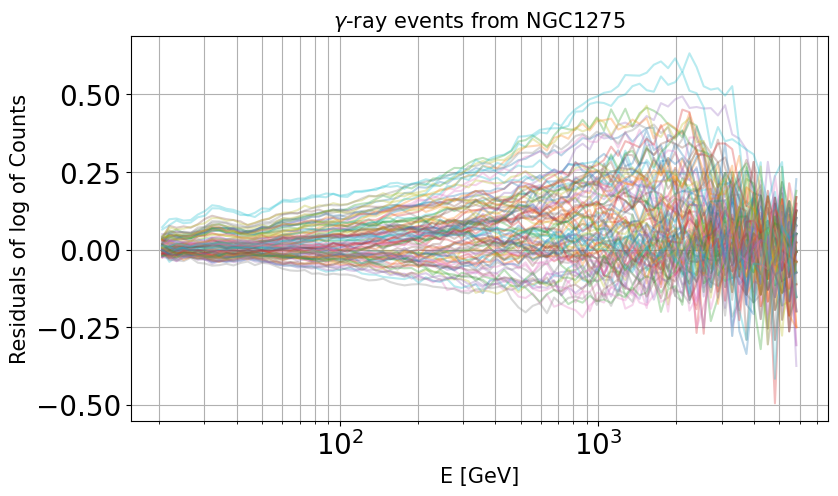

In [5]:
A.configure_plot(xmin=None, xmax=None, ymin=None,ymax=None,legend=0, logx=1, logy=0)
for i in range(min(len(samples),100)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=None,color_obs=None,linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_exp=0, transparency=0.7)

In [6]:
(np.linspace(1,1/90,samples['data'].shape[1])*samples['data'][0]).shape

(90,)

In [7]:
from scipy.stats import norm

In [8]:
def references2D(samples, max_freq=3, len_fft=2**11,max_weighted_sums=None, min_weighted_sums=None):
    try:
        linweight = np.linspace(1,1/(samples['data'].shape[1]),samples['data'].shape[1])
        weighted_samples = samples['data']*linweight
    except:
        linweight = np.linspace(1,1/samples.shape[1],samples.shape[1])
        weighted_samples = samples*linweight


    sums = np.max(weighted_samples,axis=1)

    max_sums = np.max(weighted_samples) if max_weighted_sums is None else max_weighted_sums
    min_sums = np.min(weighted_samples) if min_weighted_sums is None else min_weighted_sums
    normalized_data_sums = (sums-min_sums)/(max_sums-min_sums)

    try:
        linweight = np.linspace(1,1/(samples['power'].shape[1]),samples['power'].shape[1])
        weighted_samples = samples['power']*linweight
    except:
        len_fts = int(max_freq*len_fft)
        power = abs(np.fft.fft(samples,n=len_fft,axis=1))[...,:len_fts]
        linweight = np.linspace(1,1/power.shape[1],power.shape[1])
        weighted_samples = power*linweight
    sums = np.max(weighted_samples,axis=1)
    max_sums = np.max(weighted_samples)
    min_sums = np.min(weighted_samples)
    normalized_power_sums = (sums-min_sums)/(max_sums-min_sums)
    
    return normalized_data_sums.transpose(), normalized_data_sums.transpose(), power

In [9]:
def references2D(parsed_samples,max_freq=3, len_fft=2**11,):

    try:
        samples = parsed_samples['data']
    except IndexError:
        samples = parsed_samples

    bin_mins = np.min(samples, axis=0)
    bin_maxes = np.max(samples, axis=0)
    sums_of_standardized_bins = np.sum( ((samples-bin_mins)/(bin_maxes-bin_mins)) ,axis=1)
    max_sum = np.max(sums_of_standardized_bins)
    min_sum = np.min(sums_of_standardized_bins)
    standardized_sums_data = (sums_of_standardized_bins-min_sum)/(max_sum-min_sum)

    try:
        power = parsed_samples['power']
    except IndexError:
        len_fts = int(max_freq*len_fft)
        power = abs(np.fft.fft(samples,n=len_fft,axis=1))[...,:len_fts]

    bin_mins = np.min(power, axis=0)
    bin_maxes = np.max(power, axis=0)
    sums_of_standardized_bins = np.sum((power-bin_mins)/(bin_maxes-bin_mins),axis=1)
    max_sum = np.max(sums_of_standardized_bins)
    min_sum = np.min(sums_of_standardized_bins)
    standardized_sums_power = (sums_of_standardized_bins-min_sum)/(max_sum-min_sum)
    
    return standardized_sums_data.transpose(), standardized_sums_power.transpose(), power

In [37]:
data, power, power_spectrum = references2D(samples)

In [65]:
n_sim_coverage = 1000

In [66]:
# master_array = np.array([data,power,data**2+power**2])[:,-n_sim_coverage :]

In [76]:
# sorted_master_array = master_array[:,np.argsort(master_array[2,:])]
# sorted_data = np.sort(data[-n_sim_coverage:])
# sorted_power = np.sort(power[-n_sim_coverage:])

In [77]:
sorted_data.shape

(1000,)

In [73]:
fy

array([-0.00000000e+00, -2.63347035e-08, -1.36518577e-07, -4.27318323e-07,
       -5.75996770e-07, -2.89767510e-06, -3.34411019e-06, -4.94852247e-06,
       -5.32848082e-06, -1.29494582e-05, -1.53009306e-05, -1.55264493e-05,
       -1.84766733e-05, -2.79555092e-05, -3.40222840e-05, -3.84382835e-05,
       -4.56992854e-05, -7.72826403e-05, -9.58738608e-05, -1.22391068e-04,
       -1.44918320e-04, -1.54233336e-04, -1.56818225e-04, -5.26443754e-04,
       -7.04321299e-04, -7.31211415e-04, -7.79659891e-04, -8.34757163e-04,
       -1.05971728e-03, -1.09595874e-03, -1.43184415e-03, -1.45254810e-03,
       -1.46631691e-03, -1.63090726e-03, -1.65728132e-03, -1.88911503e-03,
       -1.92505210e-03, -1.99627674e-03, -2.14001011e-03, -2.21940661e-03,
       -2.24070809e-03, -2.33978441e-03, -2.56914841e-03, -2.58626515e-03,
       -2.60925421e-03, -2.71344188e-03, -2.81295676e-03, -2.93048519e-03,
       -3.02638100e-03, -3.26219970e-03, -3.58938542e-03, -3.59661112e-03,
       -4.21152506e-03, -

In [74]:
correction_to_data.pdf(sorted_data[n1:n])

array([0.00000000e+00, 6.03263255e-37, 2.38809159e-29, 1.01514071e-24,
       1.39860939e-24, 1.28306254e-23, 2.18952250e-23, 6.18049172e-23,
       8.12200963e-23, 1.36083968e-21, 1.68853772e-21, 1.76112384e-21,
       8.15178857e-21, 8.97079648e-21, 3.26462542e-20, 6.94484533e-20,
       1.59830328e-19, 2.35910165e-19, 6.97277632e-19, 7.06210983e-19,
       7.33179880e-19, 7.74596007e-19, 8.40324980e-19, 1.53371598e-18,
       3.24554462e-18, 4.12077794e-18, 6.59141118e-18, 1.27158378e-17,
       2.96250066e-17, 3.54502350e-17, 3.91287602e-17, 4.81765891e-17,
       5.98279893e-17, 6.85593886e-17, 8.08126532e-17, 9.35515380e-17,
       1.58621857e-16, 2.32299204e-16, 2.39604570e-16, 3.48635508e-16,
       7.06476596e-16, 9.84376601e-16, 1.10187778e-15, 2.36863640e-15,
       2.58824748e-15, 3.48440982e-15, 5.30408313e-15, 7.94667473e-15,
       9.80715720e-15, 1.02788781e-14, 1.14320489e-14, 1.93788594e-14,
       1.97134951e-14, 2.11115937e-14, 2.88268360e-14, 3.78385826e-14,
      

In [173]:
(1-np.exp(-sorted_power[n1:n]/fitted_power_parameters[0]))

array([0.09397674, 0.10688841, 0.12220997, 0.12509996, 0.1280334 ,
       0.13680792, 0.14198667, 0.14210254, 0.14329916, 0.14360344,
       0.14432448, 0.14703798, 0.14824808, 0.15084457, 0.15239781,
       0.15757066, 0.15955997, 0.15987623, 0.16196269, 0.16319042,
       0.16453606, 0.1658073 , 0.1660567 , 0.1665824 , 0.16766238,
       0.1684224 , 0.1691885 , 0.17065644, 0.17250687, 0.17313862,
       0.1742459 , 0.17570013, 0.17687392, 0.17886347, 0.17911696,
       0.17960674, 0.18091589, 0.18316638, 0.1838491 , 0.1838848 ,
       0.18410856, 0.18521398, 0.1861574 , 0.18730342, 0.1875031 ,
       0.18798828, 0.18837684, 0.18843192, 0.18898892, 0.18907642,
       0.18988746, 0.19131953, 0.19146204, 0.19146621, 0.19210738,
       0.19277483, 0.19440454, 0.19474018, 0.19858223, 0.19859165,
       0.19868779, 0.19934726, 0.19973987, 0.20105064, 0.20110732,
       0.20238948, 0.20248824, 0.20306528, 0.20355672, 0.2042579 ,
       0.20613617, 0.2065652 , 0.2076422 , 0.20766413, 0.20853

In [239]:
np.pi*(0.3)*0.5

0.47123889803846897

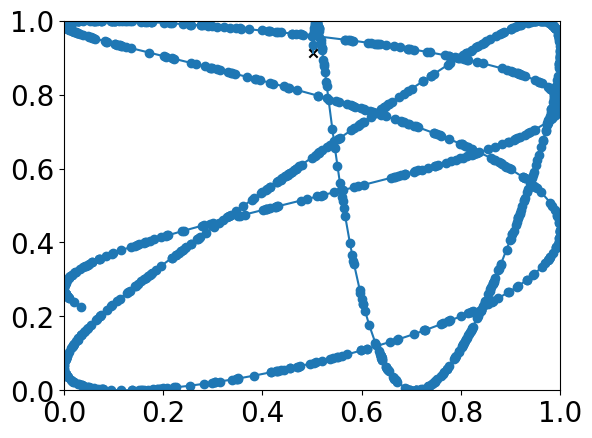

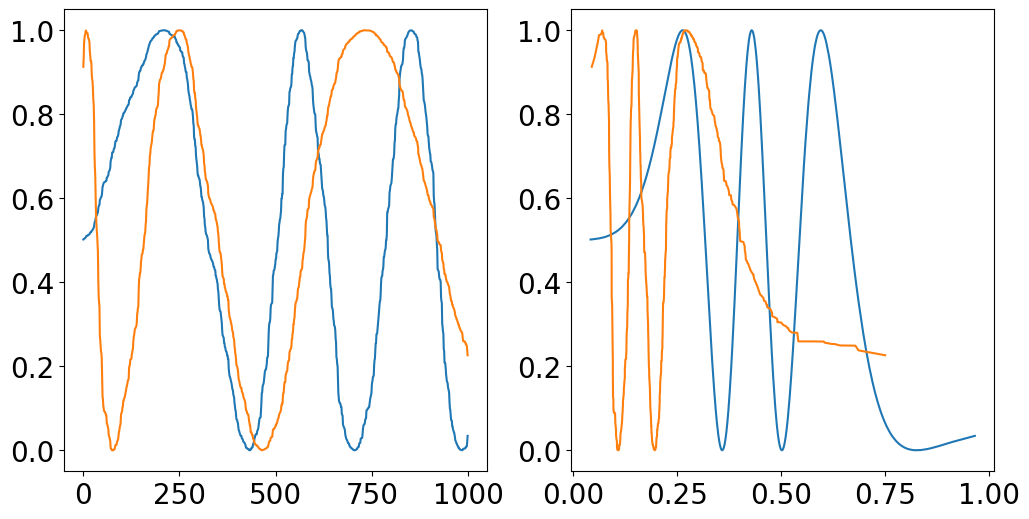

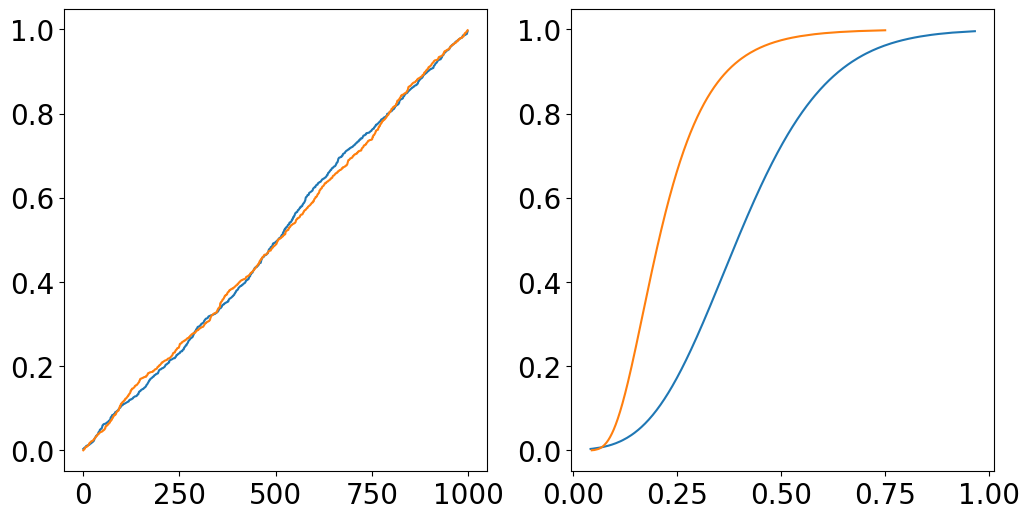

In [285]:
n1 = 0
n = 1000

sorted_data = np.sort(data[-n_sim_coverage:])
sorted_power = np.sort(power[-n_sim_coverage:])

rndphsx = np.random.uniform(0,1)
rndphsy = np.random.uniform(0,1)
rndphs2x = np.random.uniform(0,1)
rndphs2y = np.random.uniform(0,1)

# correction_to_data = lognorm(s=0.37, scale=0.42)#lognorm(s=0.6, scale=0.24)
correction_to_data = lognorm(fitted_parameters[0], fitted_parameters[1], fitted_parameters[2]).pdf(sorted_data[n1:n])
correction_to_power = lognorm(fitted_power_parameters[0], fitted_power_parameters[1], fitted_power_parameters[2]).pdf(sorted_data[n1:n])
fx =  correction_to_data*(1.1 + 0.5*(1.1-1)*(np.sin(2*np.pi*sorted_data[n1:n]*2 + rndphsx) + 1 ) )/np.max(correction_to_data)
# fx =  (0.4 + 0.5*(1-0.4)*(np.sin(2*np.pi*sorted_data[n1:n]*2 + rndphsx) + 1 ) )
# fx = 1
fx = correction_to_data/np.max(correction_to_data)
fy =  correction_to_power*(1.1 + 0.5*(1.1-1)*(np.sin(2*np.pi*sorted_power[n1:n]*5*2 + rndphsy) + 1 ) )/np.max(correction_to_power)
fy = 2
fy = 2*correction_to_power/np.max(correction_to_power)
fy = -fy

phsx = lognorm(fitted_parameters[0], fitted_parameters[1], fitted_parameters[2]).cdf(sorted_data[n1:n])
phsy = lognorm(fitted_power_parameters[0], fitted_power_parameters[1], fitted_power_parameters[2]).cdf(sorted_power[n1:n])
# phsx = sorted_data[n1:n]
# phsy = sorted_power[n1:n]

xs = np.zeros(n-n1)
ys = np.zeros(n-n1)

xs = 0.5 + 0.5*np.sin(2*np.pi*((2*phsx +0*3*phsy)**1.5))
ys = 0.5 + 0.5*np.sin(3*np.pi*((3*phsx +0*2*phsy)**0.5))

plt.figure(0)
plt.scatter(xs[1:],ys[1:])
plt.scatter(xs[0],ys[0],marker='x',color='k')
plt.plot(xs,ys)
plt.xlim([0,1])
plt.ylim([0,1])
plt.figure(1,figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(xs)
plt.plot(ys)
plt.subplot(1,2,2)
plt.plot(sorted_data,xs)
plt.plot(sorted_power,ys)
plt.figure(2,figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(phsx)
plt.plot(phsy)
plt.subplot(1,2,2)
plt.plot(sorted_data,phsx)
plt.plot(sorted_power,phsy)

In [159]:
matches

array([613, 332, 317, 512, 533])

In [184]:
t = np.linspace(0,1,1000)

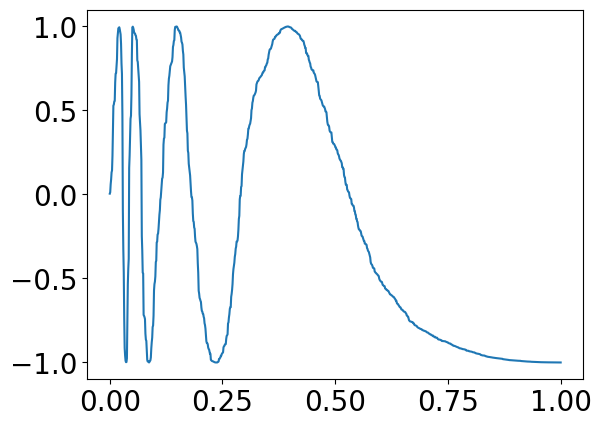

In [214]:
plt.plot(t,np.sin(2*np.pi*3.75*lognorm(fitted_power_parameters[0], fitted_power_parameters[1], fitted_power_parameters[2]).cdf(sorted_data[n1:n])
                 ))#*(0.99+0.5*(1.01-0.99)*np.sin(2*np.pi*10*t))  ))

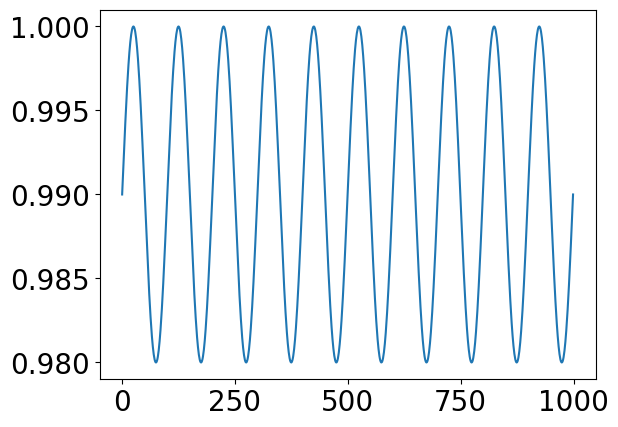

In [212]:
plt.plot( 0.99+0.5*(1.01-0.99)*np.sin(2*np.pi*10*t) ) 

In [84]:
fitted_parameters = lognorm.fit(sorted_data)

In [158]:
sorted_data

array([0.04238981, 0.04779709, 0.05865207, 0.0620633 , 0.0658301 ,
       0.06675264, 0.07215761, 0.07894044, 0.08434007, 0.08456104,
       0.08518402, 0.08526743, 0.08889652, 0.09060582, 0.09070095,
       0.09195147, 0.09353307, 0.09852839, 0.10016672, 0.10247386,
       0.10248405, 0.10328729, 0.10738779, 0.10858811, 0.10933123,
       0.11141567, 0.11428633, 0.11549074, 0.11932205, 0.12601964,
       0.12856068, 0.13017404, 0.13373375, 0.13700156, 0.13832377,
       0.139733  , 0.14055397, 0.14183034, 0.14326768, 0.14824066,
       0.15063131, 0.1516073 , 0.15220484, 0.15724245, 0.15792899,
       0.15906358, 0.16003442, 0.16022138, 0.16153158, 0.16469036,
       0.16902007, 0.16955341, 0.17110823, 0.17175809, 0.1723906 ,
       0.17253721, 0.172586  , 0.17290962, 0.17298041, 0.17353612,
       0.17358537, 0.17580307, 0.17592718, 0.17647752, 0.1770573 ,
       0.17751455, 0.17966376, 0.18012968, 0.18062282, 0.18138638,
       0.1823038 , 0.18650754, 0.18734616, 0.18868272, 0.18872

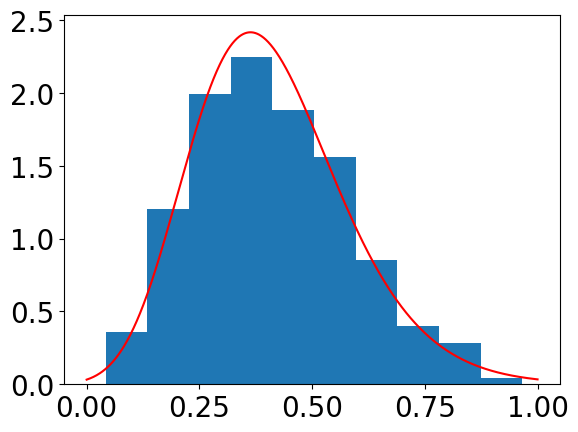

In [85]:
plt.hist(sorted_data, density=True)
x = np.linspace(0,1,1000)
fitted_parameters = lognorm.fit(sorted_data)
# plt.plot(x, lognorm(s=0.32, scale=0.40).pdf(x), color = 'r')
plt.plot(x, lognorm(fitted_parameters[0], fitted_parameters[1], fitted_parameters[2]).pdf(x), color = 'r')

0.4578485377517122

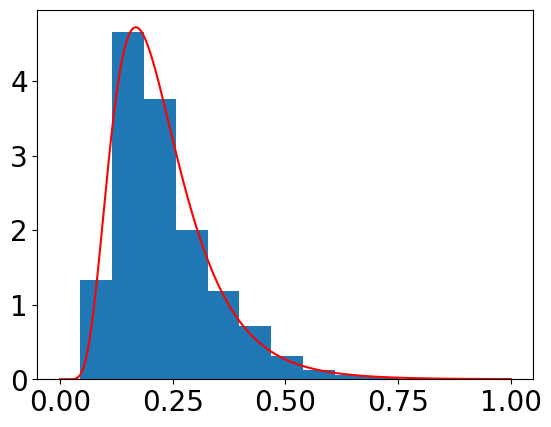

In [170]:
plt.hist(sorted_power, density=True)
x = np.linspace(0,1,1000)
fitted_power_parameters = lognorm.fit(sorted_power)
plt.plot(x, lognorm(fitted_power_parameters[0], fitted_power_parameters[1], fitted_power_parameters[2]).pdf(x), color = 'r')
fitted_power_parameters[0]

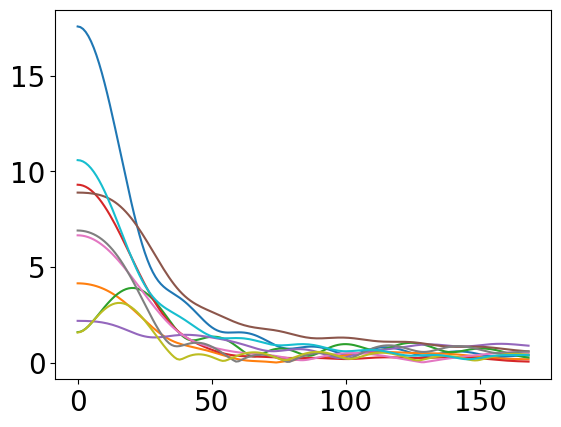

In [19]:
for i in range(10):
    plt.plot(samples['power'][i])

In [20]:
which_grid_point = priors[name]['which_grid_point']
which_truncation = priors[name]['which_truncation']
n_sim_train = priors[name]['n_sim_train'][which_grid_point]
bounds = priors[name]['bounds_rounds'][which_grid_point][which_truncation]

In [94]:
def obs_comparison(obs_vec, sample_vec,widths):
  
    return np.sum(((obs_vec-sample_vec)/widths)**2,axis=-1)

def find_obs_matches(target_obs, n=None, bounds=bounds, samples=samples, component_to_compare="exp",component_indices=[]):
    if not n: n = 5
    if len(component_indices)==0: component_indices = np.arange(samples[component_to_compare].shape[1])

    widths = np.max(samples[component_to_compare][:,component_indices],axis=0)-np.min(samples[component_to_compare][:,component_indices],axis=0)
    
    matches = np.argsort(obs_comparison(np.array([target_obs[component_to_compare]])[:,component_indices], samples[component_to_compare][:,component_indices], widths))[:n]
        
    return matches


def plot_obs_matches(target_obs, n=None, color='r', bounds=bounds, samples=samples, component_to_compare="data",component_indices=[],
                    plot_hist = False):
    if not n: n = 5
    matches = list(np.zeros(n))
    matches = find_obs_matches(target_obs, n=n, bounds=bounds, samples=samples,component_to_compare=component_to_compare, component_indices=component_indices)
    if plot_hist:
        fig_hist = plt.figure(figsize=(12,12))
        for i in range(len(bounds)):
            fig_hist.add_subplot(6,3,i+1)
            # plt.subplot(1,len(bounds),i+1)
            plt.hist(samples['params'][matches,i], range=bounds[i],bins=50)
            plt.title(A.param_names[i])
            plt.axvline(target_obs['params'][i], color='r')
    A.configure_plot(xmin = None, xmax = None, ymin=None, ymax=None, logx=1, legend = 1)
    A.compute_case(new_fig=1,null=1,plot_obs=0,color="k",linestyle="--", label_exp=1)
    for j, match in enumerate(matches):
        A.configure_model(params=samples["params"][match])
        A.import_counts(exp=samples["exp"][match],obs=samples["data"][match])
        A.compute_case(new_fig=0,new_counts=0,plot_obs=0,color=color,label_exp=0, errorbands=False, transparency=0.5)    
    
    return matches

In [117]:
n_samples

1000

In [118]:
matches

array([265, 322, 524, 282, 277])

In [119]:
data[matches]

array([0.25656196, 0.6250345 , 0.86197674, 0.14444092, 0.36720958],
      dtype=float32)

In [137]:
data[-n_sim_coverage:][matches]

array([0.78357095, 0.7691377 , 0.7429901 , 0.76543933, 0.79070807],
      dtype=float32)

In [140]:
power[-n_sim_coverage:][matches]

array([0.46814194, 0.32624596, 0.39038536, 0.33296606, 0.6031986 ],
      dtype=float32)

In [122]:
sorted_data

array([0.4318682 , 0.4912567 , 0.47238144, 0.4257698 , 0.47874403],
      dtype=float32)

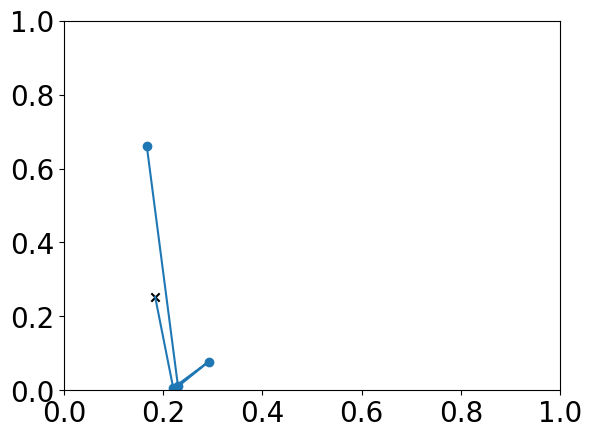

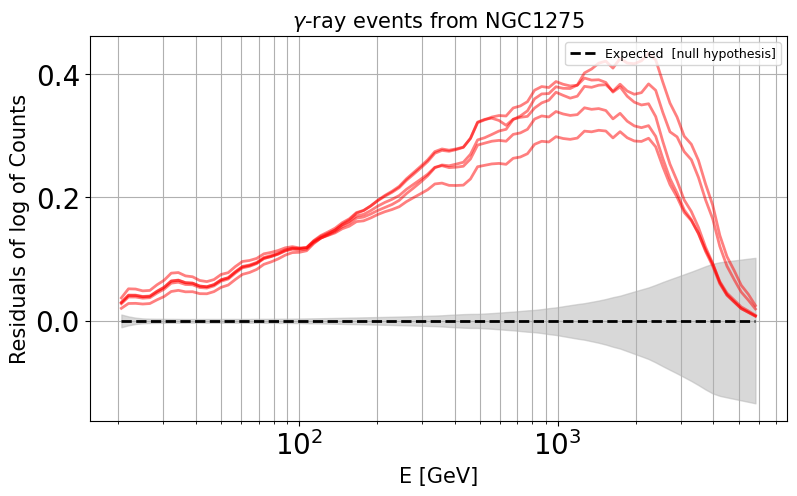

In [165]:
n_vis = 5
bounds_vis = copy.deepcopy(bounds)
target_obs = samples[0]
n_samples = max(min(10_000_000,n_sim_coverage),n_vis)

matches = find_obs_matches(target_obs, n_vis, bounds=bounds_vis, samples=samples[-n_samples:],
                           component_to_compare='data', component_indices=[])

sorted_data = data[-n_sim_coverage:][matches]
sorted_power = power[-n_sim_coverage:][matches]

n1 = 0
n = 10
# lognorm(s=0.6, scale=0.24).pdf(sorted_data)*
correction_to_data = lognorm(fitted_parameters[0], fitted_parameters[1], fitted_parameters[2]).pdf(sorted_data[n1:n])
correction_to_power = lognorm(s=0.5, scale=0.20).pdf(sorted_data[n1:n])
fx =  correction_to_data*(0.4 + 0.5*(1-0.4)*(np.sin(2*np.pi*sorted_data[n1:n]*3 + rndphsx) + 1 ) )/np.max(correction_to_data)
# fy =  correction_to_power*(5 + 0.5*(7-5)*(np.sin(2*np.pi*sorted_power[n1:n]*5*2 + rndphsy) + 1 ) )/np.max(correction_to_power)
fx = 1
fy =  correction_to_power*(10 + 0.5*(15-10)*(np.sin(2*np.pi*sorted_power[n1:n]*5*2 + rndphsy) + 1 ) )/np.max(correction_to_power)
fy = 1
fy = -fy

xs = np.zeros(n-n1)
ys = np.zeros(n-n1)

xs = 0.5 + 0.5*np.sin(2*np.pi*(sorted_data[n1:n]*fx) + rndphs2x)
ys = 0.5 + 0.5*np.sin(2*np.pi*(sorted_power[n1:n]*fy) + rndphs2y)

plt.figure()
plt.scatter(xs[1:],ys[1:])
plt.scatter(xs[0],ys[0],marker='x',color='k')
plt.plot(xs,ys)
plt.xlim([0,1])
plt.ylim([0,1])

_=plot_obs_matches(target_obs, n_vis, bounds=bounds_vis, samples=samples[-n_samples:],
                           component_to_compare='data', component_indices=[])



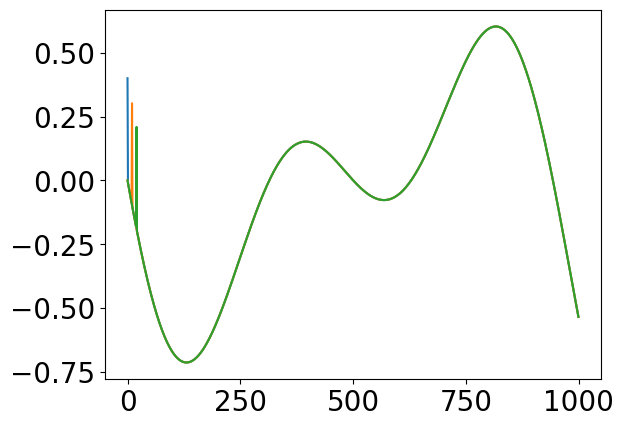

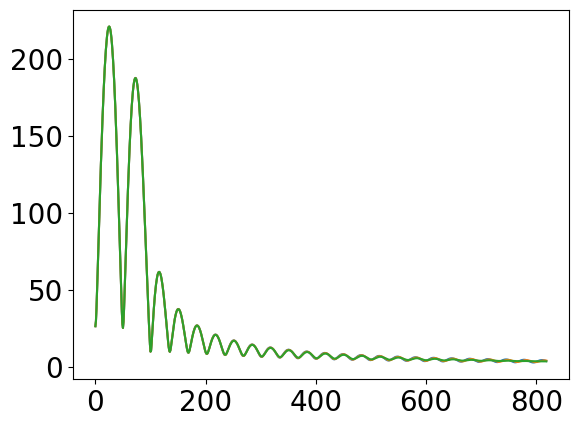

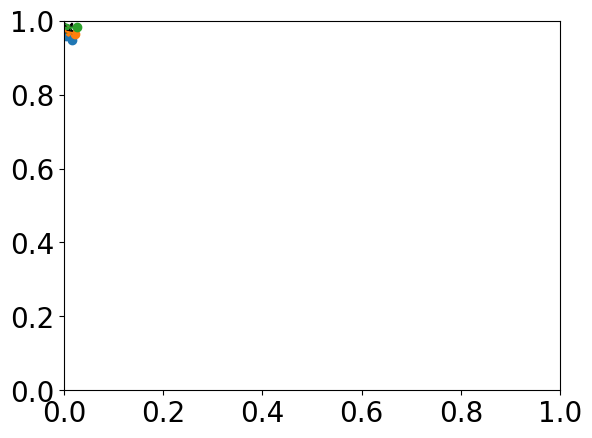

In [26]:
n = 5
bins_to_test = [0,10,20]
change_factor = 0.1

x = np.arange(0,1000)
test_samples = np.array([(0.002*x-1)*np.sin(x/100)])
# np.random.seed(0)
random_fluctuations = [2*n*change_factor*np.random.randn(len(test_samples[0])) for i in range(1000)]
test_data = np.array([ np.array( [test_samples[0] + random_fluctuations[i] for i in range(1000) ]) for _ in bins_to_test])

for bin_num, i in enumerate(bins_to_test):
    for j in range(n): 
        test_data[bin_num][j,:] = np.array(test_samples[0])
        test_data[bin_num][j,i] = test_data[bin_num][j,i] + j*change_factor 

# np.random.seed(None)
rndphsx = np.random.uniform(0,2*np.pi)
rndphsy = np.random.uniform(0,2*np.pi)

rndphs2x = np.random.uniform(0,2*np.pi)
rndphs2y = np.random.uniform(0,2*np.pi)

for bin_num, i in enumerate(bins_to_test):
    
    test_data_temp = test_data[bin_num]
    
    data, power, test_power = references2D(test_data_temp,max_freq=0.025, len_fft=2**15,)

    data = data[:n]
    power = power[:n]
    test_power = test_power[:n]
    
    plt.figure(0)
    plt.plot(test_data_temp[n-1])
    plt.figure(1)
    plt.plot(test_power[n-1])

    fx = 1/( 25 + 0.5*(30-25)*(np.sin(2*np.pi*data*17*2 + rndphsx) + 1 ) )
    fy = -1/( 20 + 0.5*(25-20)*(np.sin(2*np.pi*power*23*2 + rndphsy) + 1 ) )

    xs = np.zeros(n)
    ys = np.zeros(n)

    xs = 0.5 + 0.5*np.sin(2*np.pi*(data/fx) + rndphs2x)
    ys = 0.5 + 0.5*np.sin(2*np.pi*(power/fy) + rndphs2y)

    plt.figure(2)
    plt.scatter(xs[1:],ys[1:])
    plt.scatter(xs[0],ys[0],marker='x',color='k')
    plt.plot(xs,ys)
    plt.xlim([0,1])
    plt.ylim([0,1])

    # plt.figure(3)
    # plt.plot(xs)
    # plt.plot(ys)
    
    # print(np.mean(obs,axis=0))

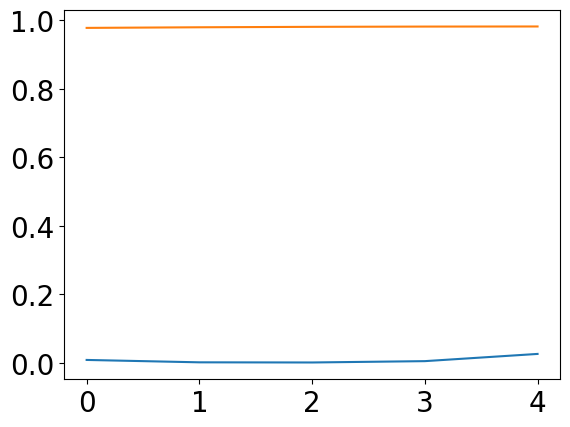

In [27]:
plt.plot(xs)
plt.plot(ys)

In [28]:
plt.plot( 20 + 0.5*(50-20)*(np.sin(2*np.pi*np.mean(obs,axis=0) + rndphsx) + 1 ) )  
plt.plot( -(20 + 0.5*(50-20)*(np.sin(2*np.pi*np.mean(obs,axis=0) + rndphsy) + 1 ) ) )

NameError: name 'obs' is not defined